In [23]:
from pathlib import Path
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt


# Find repo root (directory containing "src/")
ROOT = Path.cwd().resolve()
while not (ROOT / "src").exists():
    if ROOT.parent == ROOT:
        raise RuntimeError("Could not find project root")
    ROOT = ROOT.parent

print("Project root:", ROOT)

Project root: C:\Users\20221529\OneDrive - TU Eindhoven\Desktop\Data Preperation\BigAssignment\data-preparation-2026-group-project


In [18]:
BASE = ROOT / "src" / "project" / "temp" / "biking"

files = {
    "baseline":  BASE / "biking_test_raw.parquet",
    "corrupted": BASE / "biking_test_raw_corrupted.parquet",
    "cleaned":   BASE / "biking_test_raw_corrupted_cleaned.parquet",
}

# sanity check
for name, p in files.items():
    print(name, p.exists(), p)


baseline True C:\Users\20221529\OneDrive - TU Eindhoven\Desktop\Data Preperation\BigAssignment\data-preparation-2026-group-project\src\project\temp\biking\biking_test_raw.parquet
corrupted True C:\Users\20221529\OneDrive - TU Eindhoven\Desktop\Data Preperation\BigAssignment\data-preparation-2026-group-project\src\project\temp\biking\biking_test_raw_corrupted.parquet
cleaned True C:\Users\20221529\OneDrive - TU Eindhoven\Desktop\Data Preperation\BigAssignment\data-preparation-2026-group-project\src\project\temp\biking\biking_test_raw_corrupted_cleaned.parquet


In [41]:
BASE = ROOT / "src" / "project" / "temp" / "biking"
files = {
    "baseline":  BASE / "biking_test_raw.parquet",
    "corrupted": BASE / "biking_test_raw_corrupted.parquet",
    "cleaned":   BASE / "biking_test_raw_corrupted_cleaned.parquet",
}

for name, p in files.items():
    t = pq.read_table(p)
    print(f"{name:10s} rows={t.num_rows:,} cols={t.num_columns}")
    print(t.schema)

baseline   rows=10,294 cols=12
id: int64
userId: int64
sport: string
gender: string
timestamp: list<element: int64>
  child 0, element: int64
heart_rate: list<element: double>
  child 0, element: double
longitude: list<element: double>
  child 0, element: double
latitude: list<element: double>
  child 0, element: double
derived_speed: list<element: double>
  child 0, element: double
derived_distance: list<element: double>
  child 0, element: double
time_elapsed: list<element: int64>
  child 0, element: int64
altitude: list<element: double>
  child 0, element: double
-- schema metadata --
pandas: '{"index_columns": [], "column_indexes": [{"name": null, "field_n' + 1884
corrupted  rows=10,294 cols=12
id: int64
userId: int64
sport: string
gender: string
timestamp: list<element: int64>
  child 0, element: int64
heart_rate: list<element: double>
  child 0, element: double
longitude: list<element: double>
  child 0, element: double
latitude: list<element: double>
  child 0, element: double
d

In [19]:
def ts_lengths(path):
    t = pq.read_table(path, columns=["timestamp"])
    ts = t["timestamp"].to_pylist()
    return np.array([len(x) for x in ts], dtype=int)

for name, fn in [
    ("baseline", "biking_test_raw.parquet"),
    ("corrupted", "biking_test_raw_corrupted.parquet"),
    ("cleaned", "biking_test_raw_corrupted_cleaned.parquet"),
]:
    L = ts_lengths(BASE / fn)
    print(f"{name:10s} n={len(L):,} min/mean/max = {L.min()} / {L.mean():.1f} / {L.max()}")


baseline   n=10,294 min/mean/max = 300 / 300.0 / 300
corrupted  n=10,294 min/mean/max = 300 / 300.0 / 300
cleaned    n=10,294 min/mean/max = 300 / 300.0 / 300


In [21]:
def flatten_seq(table, col, max_workouts=200):
    seqs = table[col].to_pylist()[:max_workouts]
    return np.concatenate([np.asarray(s, dtype=float) for s in seqs if len(s) > 0])

raw   = pq.read_table(BASE / "biking_test_raw.parquet")
corr  = pq.read_table(BASE / "biking_test_raw_corrupted.parquet")
clean = pq.read_table(BASE / "biking_test_raw_corrupted_cleaned.parquet")

for col in ["heart_rate", "derived_speed", "altitude"]:
    x0 = flatten_seq(raw, col)
    x1 = flatten_seq(corr, col)
    x2 = flatten_seq(clean, col)

    n = min(len(x0), len(x1), len(x2))
    x0, x1, x2 = x0[:n], x1[:n], x2[:n]

    d_corr  = float(np.mean(np.abs(x1 - x0)))
    d_clean = float(np.mean(np.abs(x2 - x0)))
    print(f"{col:15s} | corrupted Δ={d_corr:.4f} | cleaned Δ={d_clean:.4f}")

heart_rate      | corrupted Δ=14.6649 | cleaned Δ=17.5321
derived_speed   | corrupted Δ=7.9656 | cleaned Δ=21.8366
altitude        | corrupted Δ=27.4731 | cleaned Δ=23.6203


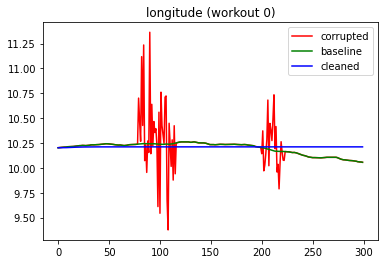

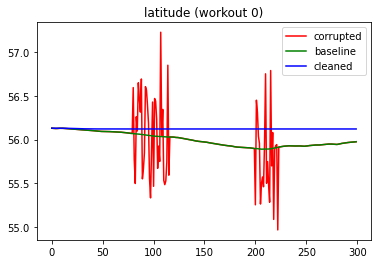

In [50]:
BASE = ROOT / "src" / "project" / "temp" / "biking"
i = 0  # change this index to inspect different workouts

raw   = pq.read_table(BASE / "biking_test_raw.parquet", columns=["longitude","latitude"])
corr  = pq.read_table(BASE / "biking_test_raw_corrupted.parquet", columns=["longitude","latitude"])
clean = pq.read_table(BASE / "biking_test_raw_corrupted_cleaned.parquet", columns=["longitude","latitude"])

def plot_col(col):
    plt.figure()
    
    plt.plot(corr[col][i].as_py(), label="corrupted", color="red")
    plt.plot(raw[col][i].as_py(), label="baseline", color="green")
    plt.plot(clean[col][i].as_py(), label="cleaned", color="blue")
    plt.title(f"{col} (workout {i})")
    plt.legend()
    plt.show()

for c in ["longitude", "latitude"]:
    plot_col(c)

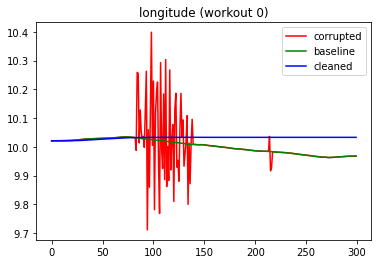

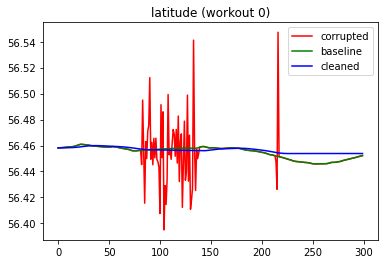

In [51]:
BASE = ROOT / "src" / "project" / "temp" / "running"
i = 0  # change this index to inspect different workouts

raw   = pq.read_table(BASE / "running_test_raw.parquet", columns=["longitude","latitude"])
corr  = pq.read_table(BASE / "running_test_raw_corrupted.parquet", columns=["longitude","latitude"])
clean = pq.read_table(BASE / "running_test_raw_corrupted_cleaned.parquet", columns=["longitude","latitude"])

def plot_col(col):
    plt.figure()
    
    plt.plot(corr[col][i].as_py(), label="corrupted", color="red")
    plt.plot(raw[col][i].as_py(), label="baseline", color="green")
    plt.plot(clean[col][i].as_py(), label="cleaned", color="blue")
    plt.title(f"{col} (workout {i})")
    plt.legend()
    plt.show()

for c in ["longitude", "latitude"]:
    plot_col(c)

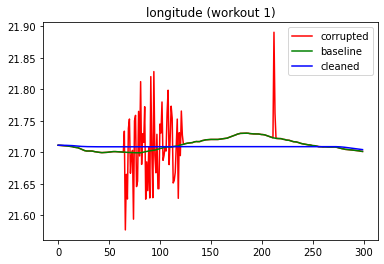

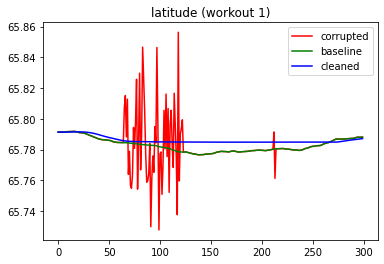

In [52]:
BASE = ROOT / "src" / "project" / "temp" / "walking"
i = 1  # change this index to inspect different workouts

raw   = pq.read_table(BASE / "walking_test_raw.parquet", columns=["longitude","latitude"])
corr  = pq.read_table(BASE / "walking_test_raw_corrupted.parquet", columns=["longitude","latitude"])
clean = pq.read_table(BASE / "walking_test_raw_corrupted_cleaned.parquet", columns=["longitude","latitude"])

def plot_col(col):
    plt.figure()
    
    plt.plot(corr[col][i].as_py(), label="corrupted", color="red")
    plt.plot(raw[col][i].as_py(), label="baseline", color="green")
    plt.plot(clean[col][i].as_py(), label="cleaned", color="blue")
    plt.title(f"{col} (workout {i})")
    plt.legend()
    plt.show()

for c in ["longitude", "latitude"]:
    plot_col(c)